<a href="https://colab.research.google.com/github/khammernik/AI4doctors/blob/master/AI4doctors_inverse_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This tutorial consists of two parts. In the first part, you will be playing with the task of image denoising and solving a linear and regularized reconstruction problem. Furthermore, we apply a pre-trained network to our unseen brain data. In the second part, you will get introduced to the world of MRI reconstruction. We start with examining the raw k-space data and coil-sensitivity maps and build the multi-coil forward and adjoint operator. Additionally, we solve a linear and a regularized reconstruction problem, allow us to deeply understand where we can connect with machine learning.

First, we install the dependencies and download the data.

In [ ]:
# install dependencies
!pip install PyWavelets git+https://github.com/khammernik/medutils.git

  Cloning https://github.com/khammernik/medutils.git to /tmp/pip-req-build-ltgf_e0i
  Running command git clone -q https://github.com/khammernik/medutils.git /tmp/pip-req-build-ltgf_e0i


In [ ]:
# download data
!wget -O brain_cartesian_2D_removeOS.h5 https://www.dropbox.com/s/282e0nabg8l1ruh/brain_cartesian_2D_removeOS.h5?dl=1
!wget -O brain_cartesian_2D.h5 https://www.dropbox.com/s/hclfv3re91qb1v3/brain_cartesian_2D.h5?dl=1
!wget -O brain.npy https://www.dropbox.com/s/jphs92fn3mypqhx/brain.npy?dl=1
!wget -O vrs_mask.npy https://www.dropbox.com/s/u4nj45gkk7ejb5a/vrs_mask.npy?dl=1

--2022-05-13 23:14:45--  https://www.dropbox.com/s/282e0nabg8l1ruh/brain_cartesian_2D_removeOS.h5?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/282e0nabg8l1ruh/brain_cartesian_2D_removeOS.h5 [following]
--2022-05-13 23:14:45--  https://www.dropbox.com/s/dl/282e0nabg8l1ruh/brain_cartesian_2D_removeOS.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4673a92162dfc0571f035c810a.dl.dropboxusercontent.com/cd/0/get/BlMHo1Ezh60MYOFgSlonXm-VxjMfWJDfBQIyqwKakbz5Xqn9G8WApCsEsUUZyY735tQfegLfcJgncbUjrQmOl0lDdvbq4Wn0WTpq0GOkZje0EzgZ2fpK8fwIS948li31_vvetO1bsT8U_moESB5nUTnweLc7-WCvFcIJ60D9D0HCeQ/file?dl=1# [following]
--2022-05-13 23:14:46--  https://uc4673a92162dfc0571f035c810a.dl.dropboxusercontent.com/cd/0/get/BlMHo1Ezh6

# Image Denoising
This tutorial gives insights into the task of image denoising. The goal is to recover the clean image $u$, which is corrupted by additive Gaussian white noise $n$, given the noisy measurement data $f$,
$$ f = u + n. $$

The tutorial covers following denoising approaches:
- Denoising with L2 regularization
- Denoising with (smoothed) Total Variation (TV) regularization
- Denoising with a deep neural network




## Data Processing
Next, we load a single image and prepare it for image denoising by normalizing it to the range $[0,1]$.

BART toolbox not setup properly or not available


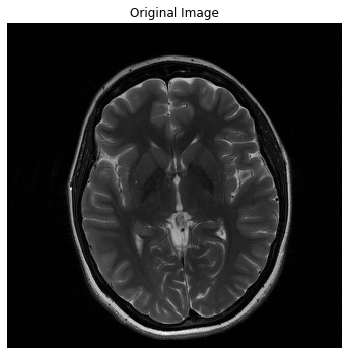

In [ ]:
import matplotlib.pyplot as plt
import medutils
import numpy as np

img = np.load('brain.npy')

# make real-valued image
img = np.abs(img)

# normalize between [0,1]
img /= np.max(img)

# show image
medutils.visualization.imshow(img, title='Original Image', figsize=(6,6))

To compare the quality of the denoising algorithms, we compute the Peak Signal to Noise ratio (PSNR) in dB as follows:
$$ \text{PSNR} = 10 \log_{10} \left(\frac{\text{max_intensity}^2}{\text{MSE}}\right),$$
where the Mean-Squared error (MSE) is defined as:
$$ \text{MSE} = \sum_{i\in\Omega} \vert u_{\text{ref},i} - u_i \vert^2. $$
Here, $u_{\text{ref}}$ defines the target (reference) image, $u$ the source image, e.g., noisy or denoised image, and $i$ denote the pixels in domain $\Omega$.



In [ ]:
def psnr(x, x_ref, max_intensity=1.0):
    """
    Compute the Peak Signal to Noise ratio (PSNR) in dB
    Args:
        x (np.array): predicted image
        x_ref (np.array): target image
    Return:
        float: Computed metric
    """
    return 10 * np.log10(max_intensity ** 2 / np.mean((x_ref-x)**2))

Now we generate a noisy image $f$ by adding Gaussian white noise of standard deviation $\sigma$.

**Task: Experiment with different levels of noise.**

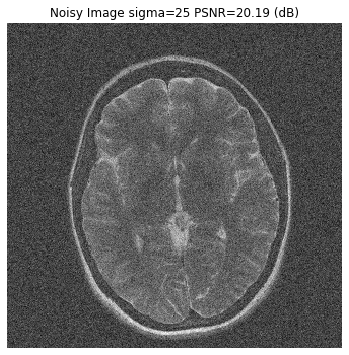

In [ ]:
# noise level for domain [0, 255]
sigma = 25

# generate noisy image
noisy = img + sigma / 255.0 * np.random.randn(*img.shape)

# plot noisy image
medutils.visualization.imshow(noisy, title=f'Noisy Image sigma={sigma} PSNR={psnr(noisy, img):0.2f} (dB)', figsize=(6,6))

## L2-H1 regularization
We regularize the least-squares problem with a regularizer of form $\mathcal{R}(u)=\frac{1}{2} \Vert \nabla u \Vert_2^2$, resulting in following minimization problem.

$$ \min_u \frac{1}{2} \Vert u - f \Vert_2^2 + \frac{\lambda}{2} \Vert \nabla u \Vert_2^2$$

The solution is given as:

$$ u - f + \lambda\nabla^\top \nabla u = 0 $$
$$ u = (I + \lambda \nabla^\top \nabla)^{-1} f $$

In [ ]:
import scipy.sparse
import scipy.sparse.linalg

def nabla_matrix(M, N):
    """ Generates the nabla matrix for a 2D image of size [M, N] """
    size = M * N
    row = np.arange(0, size)
    col = np.arange(0, size).reshape(M, N)
    fill = np.ones(size)
    col_fwd_x = np.pad(col[:,1:], [[0, 0],[0, 1]], mode='edge')
    col_bwd_y = np.pad(col[1:], [[0, 1],[0, 0]], mode='edge')
    
    dx = scipy.sparse.coo_matrix((fill, (row, col_fwd_x.flatten())), shape=(size, size)) - \
         scipy.sparse.coo_matrix((fill, (row, col.flatten())), shape=(size, size))

    dy = scipy.sparse.coo_matrix((fill, (row, col_bwd_y.flatten())), shape=(size, size)) - \
         scipy.sparse.coo_matrix((fill, (row, col.flatten())), shape=(size, size))
    
    return scipy.sparse.vstack([dx, dy])

def opt_l2h1(u, alpha):
    """ Solve linear system of equations. """
    D = nabla_matrix(*u.shape)
    v = scipy.sparse.linalg.spsolve(scipy.sparse.eye(u.size) + alpha * D.T @ D, u.flatten())
    return np.reshape(v, u.shape)

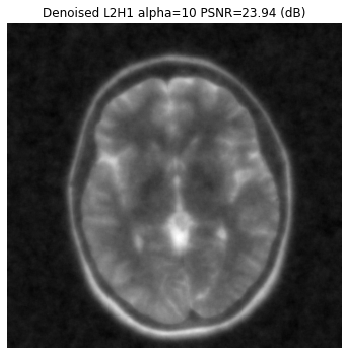

In [ ]:
alpha = 10 # regularization parameter
denoised_l2h1 = opt_l2h1(noisy, alpha=alpha)

medutils.visualization.imshow(denoised_l2h1, f'Denoised L2H1 alpha={alpha} PSNR={psnr(denoised_l2h1, img):0.2f} (dB)', figsize=(6,6))

## Denoising with Total Variation regularization.
We see that the quadratic regularizer smoothes the entire image. To alleviate this issue, a total variation (TV) regularizer can be used. The TV is given as
$$ \mathcal{R}(u) = \Vert \nabla u \Vert_{2,1} = \sum_{i\in\Omega} \sqrt{(\nabla_x u_i)^2 + (\nabla_y u_i)^2},$$ known as the ROF model, proposed by Rudin, Osher and Fatemi.
Here, $\nabla$ approximates the image gradient with finite forward differences.
The TV regularizer approximates sparsity in the image edges and favors piece-wise constant solutions. However, the TV regularizer is not differentiable which makes it challenging to solve the optimization problem. One possibility is to use the primal-dual algorithm. At this point, you do not need to understand the algorithm in detail! It is more important to find out the characteristics of the algorithm by playing around with the regularization parameter.

### Primal-Dual Algorithm
One famous algorithm to solve above problem is the [Primal-Dual Algorithm](https://link.springer.com/article/10.1007/s10851-010-0251-1) (Chambolle & Pock, 2010). We only roughly outline the primal-dual algorithm in this tutorial. More information are found in the original publication Section 6.2.1.

Consider the saddle-point problem
$$ \min_u \max_p \langle \nabla u, p \rangle + \frac{\lambda}{2}\Vert u - f \Vert_2^2 - \delta_
{\Vert p \Vert_{\infty} \leq 1}(p).$$


Set $\tau \sigma L \leq 1$, where $L$ is the Lipschitz constant, $\tau$ is the primal stepsize and $\sigma$ is the dual stepsize, respectively. Initialize $p^0=0$, $u^0=f$, $\bar{u}^0=f$. Set regularization parameter $\lambda$ and maximum number of iterations $N_k$.

For $0 \leq k < N_k$ do:

1. Perform dual update
$$ \hat{p}^{k+1} = p^{k} + \sigma \nabla \bar{u}^k$$

2. Perform projection onto infinity ball
$$ p^{k+1} = \frac{\hat{p}^{k+1}}{\max{\left(\Vert \hat{p}^{k+1} \Vert_2, 1\right)}}$$

3. Perform primal update
$$ \hat{u}^{k+1} = u^{k} - \tau \nabla^\top p^{k+1} $$ 

4. Solve proximal mapping 
$$ u^{k+1} = \arg \min_u \frac{1}{\tau} \Vert u - \hat{u}^{k+1} \Vert_2^2 + \frac{\lambda}{2}\Vert u - f\Vert_2^2 $$
which results in the update
$$ u^{k+1} = \frac{\hat{u}^{k+1} + \tau \lambda f
}{1 + \tau\lambda} $$

5. Overrelaxation
$$ \bar{u}^{k+1} = u^{k+1} + \theta (u^{k+1} - u^{k})$$

In [ ]:
def nabla(x):
    dx = np.pad(x[:,1:], [[0, 0],[0, 1]], mode='edge')
    dy = np.pad(x[1:], [[0, 1],[0, 0]], mode='edge')
    return np.concatenate([dx[None,...] - x, dy[None,...] - x], 0)

def nablaT(x):
    assert x.shape[0] == 2
    dx = np.pad(x[0,:,:-1], [[0, 0],[1, 0]], mode='constant')
    dy = np.pad(x[1,:-1], [[1, 0],[0, 0]], mode='constant')
    return dx - x[0] + dy - x[1] 

In [ ]:
def primal_dual(f, alpha, max_iter):
    p = np.zeros_like(nabla(f))
    u = f.copy()
    u_old = f.copy()
    u_bar = f.copy()

    L = 8.0
    sigma = 1.0 / np.sqrt(L)
    tau = 1.0 / np.sqrt(L)

    theta = 1.0

    for i in range(max_iter):
        # dual update
        p_ = p.copy() + sigma * nabla(u_bar)
        # dual projection
        norm_p = np.sqrt(p_[0]**2 + p_[1]**2)
        p = p_ / np.maximum(np.ones_like(norm_p), norm_p)
        # primal update
        u_ = u.copy() - tau * nablaT(p)
        # primal proximal step
        u = (u_ + tau * alpha * f) / (1 + tau * alpha)
        # over-relaxation
        u_bar = u + theta * (u - u_old)
        u_old = u.copy()
    return u

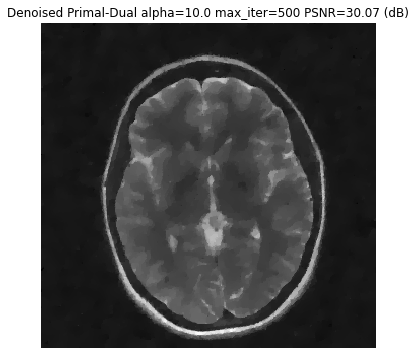

In [ ]:
alpha = 10.0
max_iter = 500
denoised_pd = primal_dual(noisy, alpha=alpha, max_iter=max_iter)

medutils.visualization.imshow(denoised_pd, f'Denoised Primal-Dual alpha={alpha} max_iter={max_iter} PSNR={psnr(denoised_pd, img):0.2f} (dB)', figsize=(6,6))

## Image Denoising Network
The following code downloads the DnCNN denoising network and applies it to our image denoising task. Note that the image was trained on natural images.

Zhang et al. [Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising](https://ieeexplore.ieee.org/document/7839189). IEEE Transactions on Image Processing, vol. 26, no. 7, pp. 3142-3155, 2017.

In [ ]:
import os
from tensorflow.keras.models import model_from_json

if not os.path.exists('./trained_models'):
    os.makedirs('./trained_models')

if not os.path.exists('./trained_models/dncnn.json'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.json -O ./trained_models/dncnn.json')

if not os.path.exists('./trained_models/dncnn.h5'):
    os.system('wget https://raw.githubusercontent.com/cszn/DnCNN/master/TrainingCodes/dncnn_keras/models/DnCNN_sigma25/model.h5 -O ./trained_models/dncnn.h5')
    
json_file = open('trained_models/dncnn.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights('./trained_models/dncnn.h5')

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input0 (InputLayer)            [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   640         ['input0[0][0]']                 
                                64)                                                               
                                                                                                  
 relu2 (Activation)             (None, None, None,   0           ['conv1[0][0]']                  
                                64)                                                         

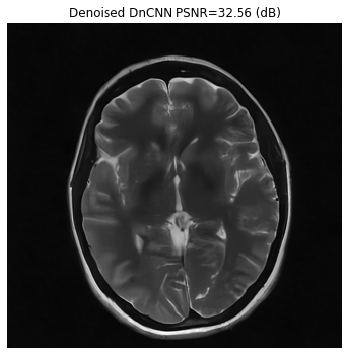

In [ ]:
def to_tf(x):
    return x[None,...,None]

def from_tf(x):
    return np.squeeze(x)

denoised_dncnn = from_tf(model.predict(to_tf(noisy)))

medutils.visualization.imshow(denoised_dncnn, title=f'Denoised DnCNN PSNR={psnr(denoised_dncnn, img):0.2f} (dB)', figsize=(6,6))

# Magnetic Resonance Image (MRI) Reconstruction

This tutorial gives insights into the task of MRI reconstruction. The goal is to recover the clean image $u$, which is obtained by undersampled k-space data $f$ and corrupted by additive Gaussian white noise $n$,
$$ f = Au + n. $$
The rawdata $f$ was aquired for multiple receive coils. The linear operator $A$ denotes the mapping from image space to k-space.



## Data Loading

In the first step, we examine the avaiable data regarding their shape and their datatype. Note, that we are dealing with complex-valued data here.

In [ ]:
import h5py
import numpy as np
import medutils

ds = h5py.File('./brain_cartesian_2D.h5', 'r')
kspace = ds['kspace'][()]
smaps = ds['smaps'][()]
ds.close()

print(f'K-Space:')
print(f'dtype={kspace.dtype}')
print(f'(nCoils, nFE, nPE)={kspace.shape}')
nCoils, nFE, nPE = kspace.shape
print('')
print(f'Smaps:')
print(f'dtype={smaps.dtype}')
print(f'(nCoils, nFE, nPE)={smaps.shape}')

K-Space:
dtype=complex64
(nCoils, nFE, nPE)=(16, 640, 330)

Smaps:
dtype=complex64
(nCoils, nFE, nPE)=(16, 640, 330)


We observe that we have 16 coils, the number of frequency encoding (readout) points `nFE` equals 640, and the number of phase encoding steps is 330. We will come back to this later.

## Data Visualization
For data visualization, you are free to use any plotting library such as `matplotlib` or use the provided `medutils` package. The `medutils` package has some useful function for visualization:
- `kshow` Process the data in log-space
- `plot_array` Re-arrange the images from a 3D array next to each other.

We will first visualize the `kspace` and the coil sensitivity maps `smaps`. The coil sensitivity maps are smooth maps that show us in which parts the single coil elements are sensitive. We will need these information for reconstruction.


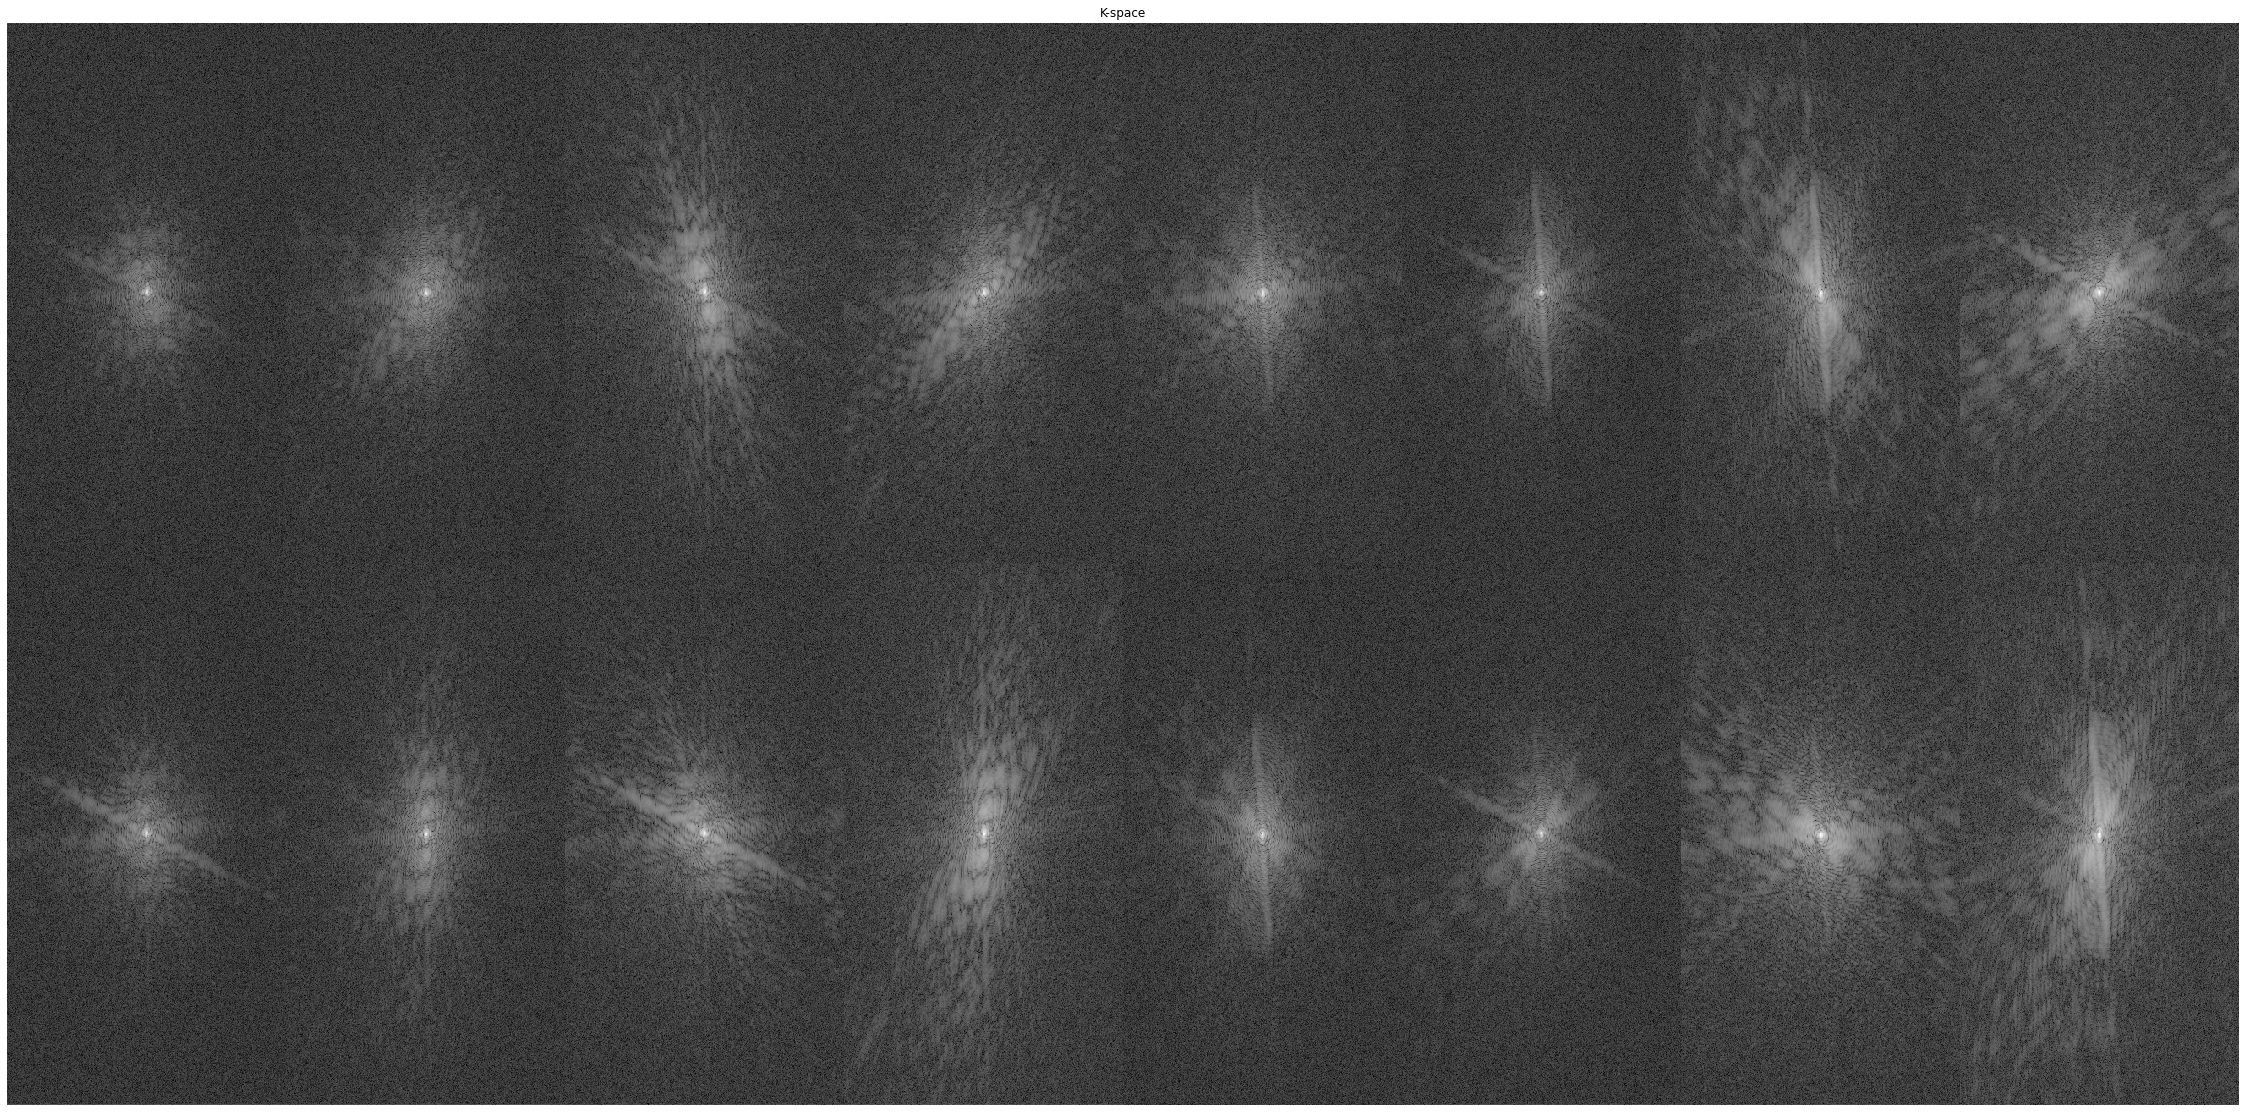

In [ ]:
medutils.visualization.kshow(medutils.visualization.plot_array(kspace, M=2, N=8), title='K-space', figsize=(40,20))

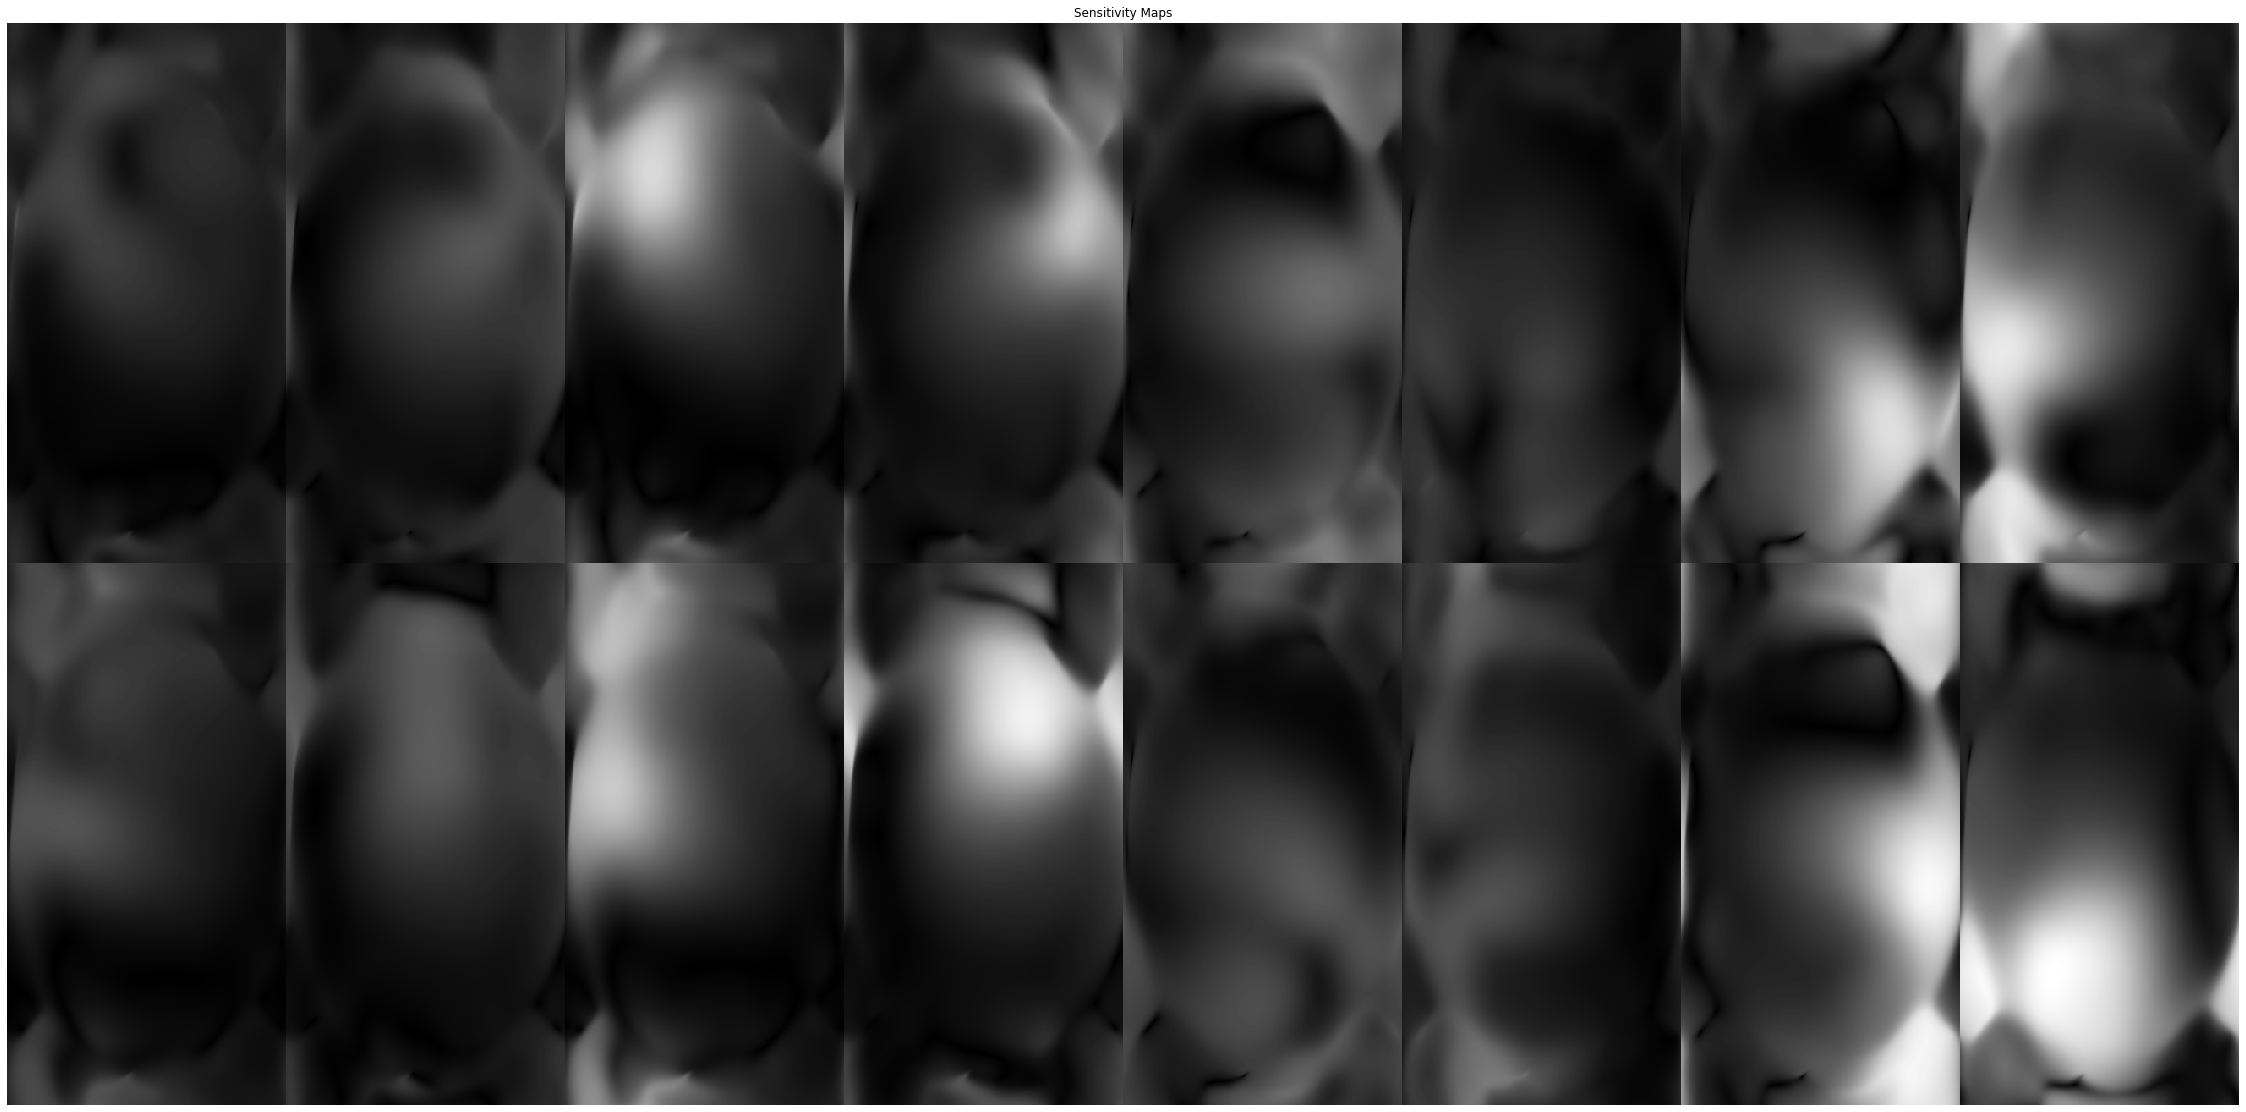

In [ ]:
medutils.visualization.imshow(medutils.visualization.plot_array(smaps, M=2, N=8), title='Sensitivity Maps', figsize=(40,20))

Let us now start to transform the `kspace` to single images. Therefore, we require the centered 2d inverse Fourier transform, which is contained in `medutils.mri.ifft2c`. Application of the `ifft2c` to the k-space results in single coil images.

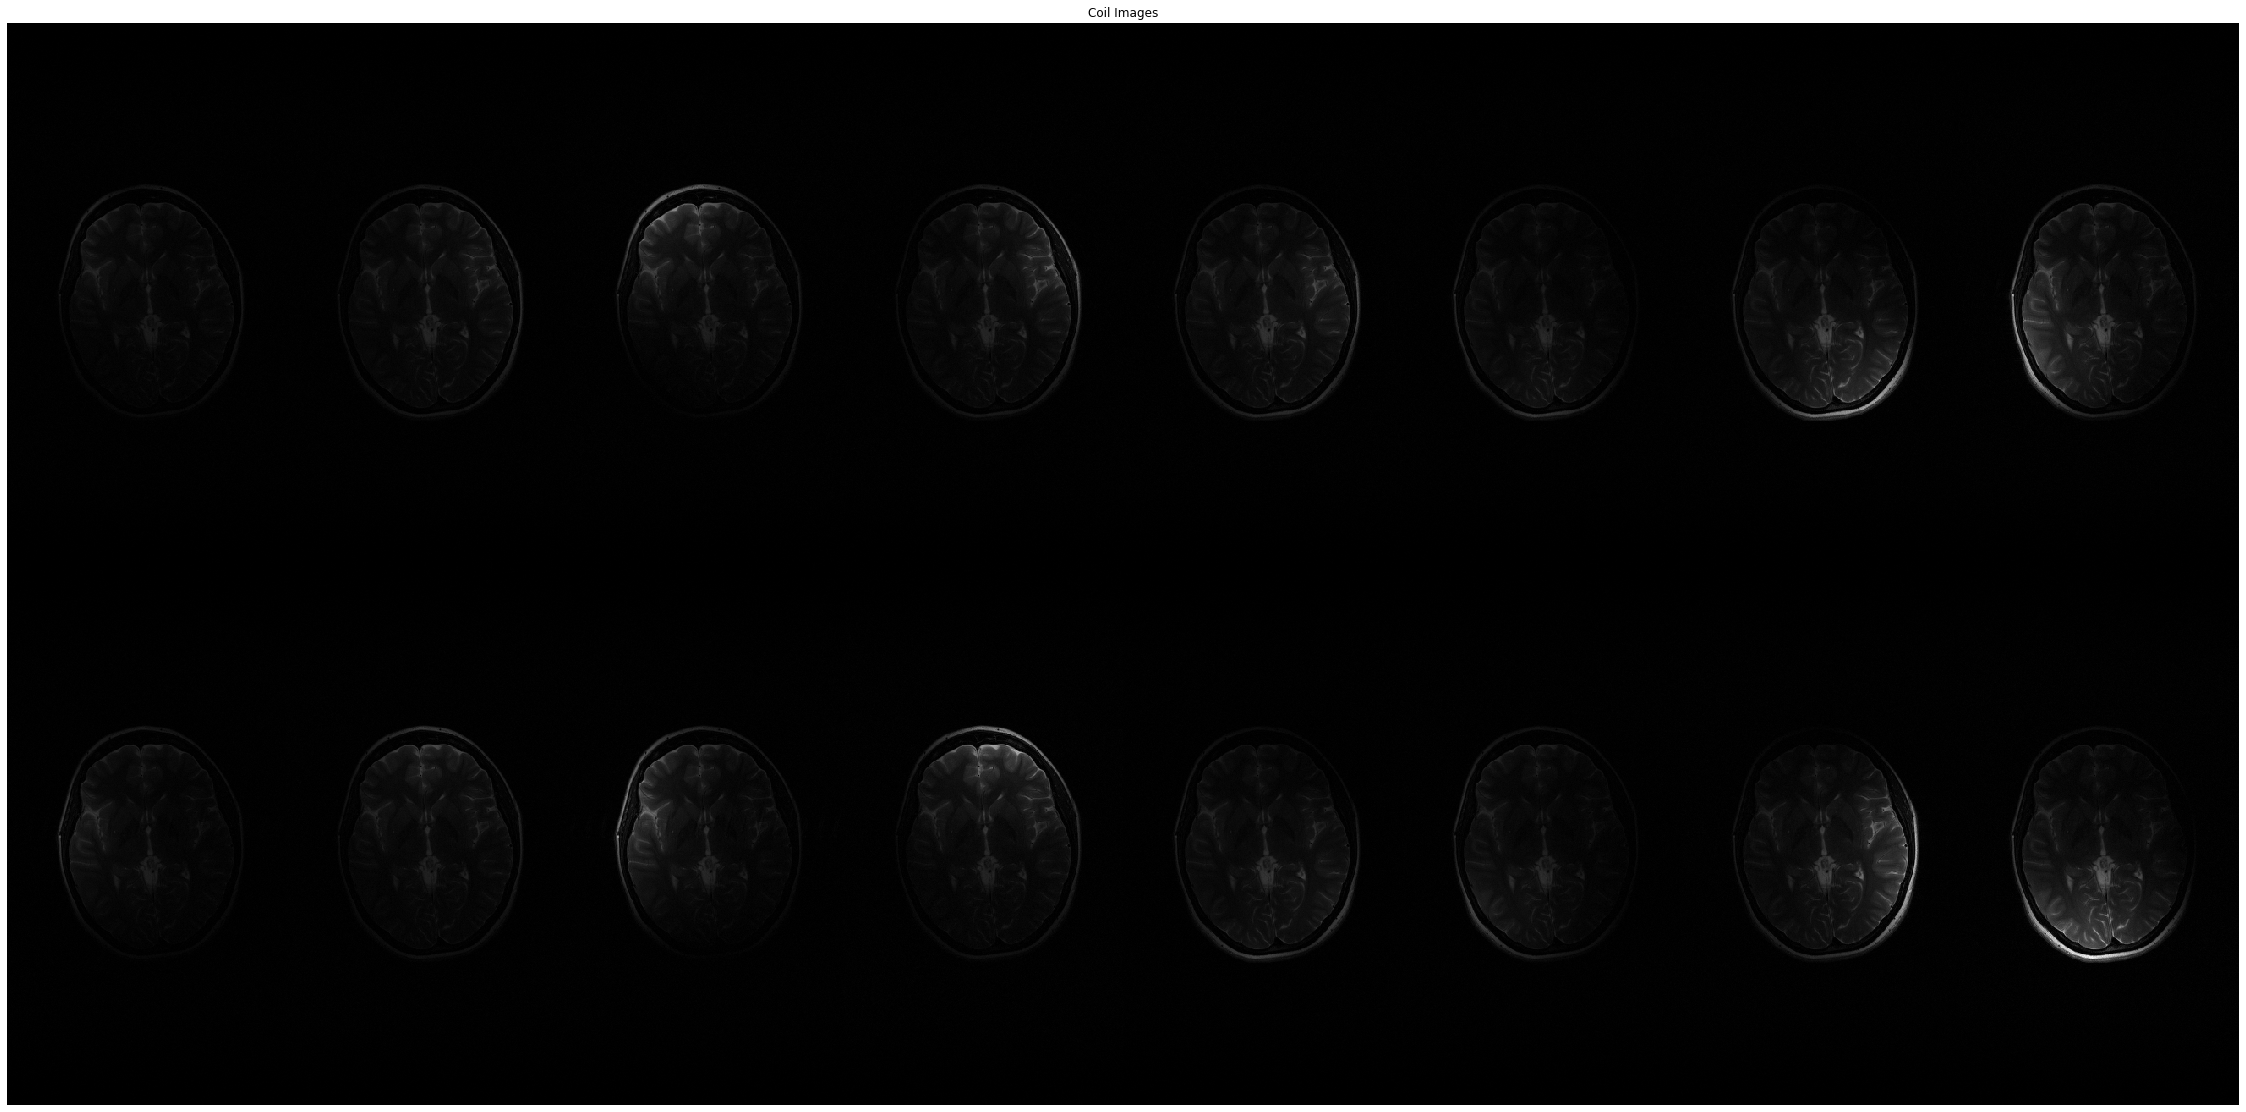

In [ ]:
coil_img = medutils.mri.ifft2c(kspace)
medutils.visualization.imshow(medutils.visualization.plot_array(coil_img, M=2, N=8), title='Coil Images', figsize=(40,20))

You might notice several things. First, you see that only a fraction of the image is bright. This is due to the effect that the coils are sensitive only in a certain spatial region. Second, you might notice that there are a lot of black areas all over the image, especially in y direction. This extended field of view in read-out direction, also termed frequency-encoding direction is actually for free, does not cost any additional acquisition time, and is implemented per default on MRI scanners.  Assuming the base resolution is 320, the number of frequency encoding steps is doubled. This frequency oversampling results in an increased field-of-view in this direction. After the image is transformed to image domain, only the central part needs to be visualized. However, for display, we will from now on only consider the central part.

## Sensitivity-Weighted Coil Combination
Now, we have all ingredients to combine the image! Do you remember how the forward and adjoint MRI multi-coil operators are defined? These are required in the next step. We first compute the coil-combined image. Right now, there is no undersampling mask involved, i.e., it is set to all ones.

Pruessmann et al. [SENSE: Sensitivity encoding for fast MRI](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291522-2594%28199911%2942%3A5%3C952%3A%3AAID-MRM16%3E3.0.CO%3B2-S) Magnetic Resonance in Medicine, 43(5):952-962, 1999.

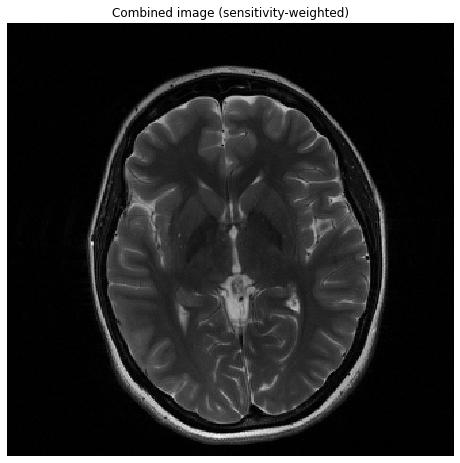

In [ ]:
img_cc = medutils.mri.mriAdjointOp(kspace, smaps, np.ones_like(kspace), fft_axes=(-2,-1), coil_axis=0)
img_cc = medutils.visualization.center_crop(img_cc, (nFE//2, nPE))
medutils.visualization.imshow(img_cc, title='Combined image (sensitivity-weighted)', figsize=(8,8))


## Undersampling
Now it is your turn! We require undersampling masks for acceleration `R`. Your task is to play around with different patterns:
- only set a dense block of `nRef` lines in the center of k-space.
- only set every `R`-th line
- combine both
- load variable density sampling from file `vrs_mask.npy`

Note that the effective acceleration `Reff` is determined by the number of `nPE` lines divided by the sum of a single PE line in the mask.

Reff=3.5


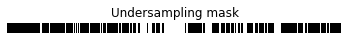

In [ ]:
R = 3
nRef = 20
mask = np.ones(nPE)
#TODO: Set every R-th line to one
#TODO: Set nRef center lines to one
mask = np.load('vrs_mask.npy')
Reff = mask.size/np.sum(mask)

mask = mask.reshape(1, nPE).repeat(nFE, axis=0)

mask_visualize = medutils.visualization.center_crop(mask, (10, nPE))
medutils.visualization.imshow(mask_visualize, 'Undersampling mask')
print(f'Reff={Reff:0.2g}')

Now you are ready to estimate the zero filling solution by applying the adjoint operator to the data, by applying the estimated undersampling mask `mask`. Play around with above mask configurations. How do the images change?

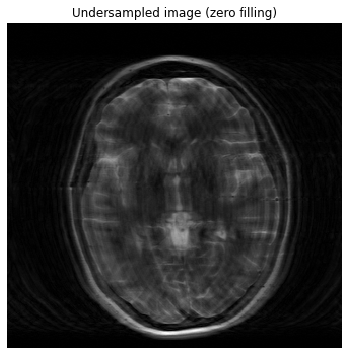

In [ ]:
# Apply the adjoint operator to the data and use the newly created undersampling mask.
img_cc_us = medutils.mri.mriAdjointOp(kspace, smaps, mask, fft_axes=(-2,-1), coil_axis=0)
img_cc_us = medutils.visualization.center_crop(img_cc_us, (nFE//2, nPE))
medutils.visualization.imshow(img_cc_us, 'Undersampled image (zero filling)', figsize=(6,6))

# Linear and Regularized Reconstruction
Now, we are ready to implement linear and regularized reconstruction. We additionally need the gradient operator, implementing forward / backward differences in `D` and `DT`, and the multi-coil MRI forward and adjoint operators, `A` and `AH`, respectively.

In [ ]:
def nabla(x):
    dx = np.pad(x[:,1:], [[0, 0],[0, 1]], mode='edge')
    dy = np.pad(x[1:], [[0, 1],[0, 0]], mode='edge')
    return np.concatenate([dx[None,...] - x, dy[None,...] - x], 0)

def nablaT(x):
    assert x.shape[0] == 2
    dx = np.pad(x[0,:,:-1], [[0, 0],[1, 0]], mode='constant')
    dy = np.pad(x[1,:-1], [[1, 0],[0, 0]], mode='constant')
    return dx - x[0] + dy - x[1] 

D = lambda x: nabla(np.real(x)) + 1j * nabla(np.imag(x))
DT= lambda x: nablaT(np.real(x)) + 1j * nablaT(np.imag(x))

In [ ]:
A = lambda x: medutils.mri.mriForwardOp(x, smaps, mask)
AH = lambda x: medutils.mri.mriAdjointOp(x, smaps, mask)

## Solving the linear reconstruction problem
Consider the following minimization problem:

$$ \min_x  E(x,y) = \min_x \Vert Ax - y \Vert_2^2 $$

While in image denoising we are still able to compute a closed-form solution for this problem, this is not feasible for the task of MRI reconstruction any more. We instead use first-order optimization methods and solve this by Gradient Descent:
$$ x^{t+1} = x^{t} - \alpha \nabla_x E(x,y) $$
$$ x^{t+1} = x^{t} - \alpha A^H (Ax^t - y) $$

In [ ]:
def opt_linear(y, max_iter=10, alpha=0.1):
    x = np.zeros_like(AH(y))

    for _ in range(max_iter):
        x = x - alpha * AH(A(x) - y)
    return x

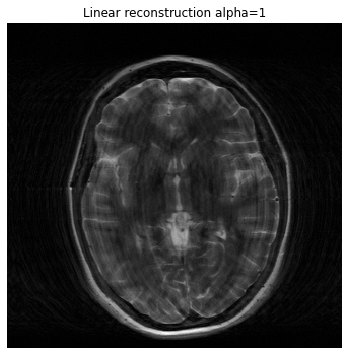

In [ ]:
alpha=1
img_linear = opt_linear(kspace, max_iter=10, alpha=alpha)
img_linear = medutils.visualization.center_crop(img_linear, (nFE//2, nPE))
medutils.visualization.imshow(img_linear, f'Linear reconstruction alpha={alpha}', figsize=(6,6))

## L2-H1 Regularization

Similar to image denoising above, we regularize the least-squares problem with a regularizer of form $\mathcal{R}(x)=\frac{1}{2} \Vert \nabla x \Vert_2^2$, resulting in following minimization problem.
Consider now the following minimization problem

$$ \min_x  D(x,y) + \lambda R(x) = \min_x \frac{1}{2}\Vert Ax - y \Vert_2^2 + \frac{\lambda}{2}\Vert \nabla x \Vert_2^2.$$

In the easiest way, we solve this by Gradient Descent:
$$ x^{t+1} = x^{t} - \alpha \left( \nabla_x D(x,y) + \nabla_x R(x) \right) $$
$$ x^{t+1} = x^{t} - \alpha \left( A^H (Ax^t - y) + \lambda \nabla^T \nabla x \right) $$

In [ ]:
def opt_reg_l2(y, max_iter=10, alpha=0.1, lambd=1.0):
    x = np.zeros_like(AH(y))

    for _ in range(max_iter):
        x = x - alpha * (AH(A(x) - y) + lambd * DT(D(x)))
    return x

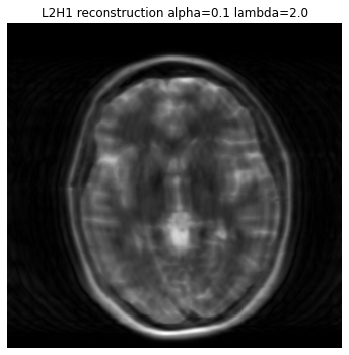

In [ ]:
alpha = 0.1
lambd = 2.0
img_reg_l2 = opt_reg_l2(kspace, max_iter=100, alpha=alpha, lambd=lambd)
img_reg_l2 = medutils.visualization.center_crop(img_reg_l2, (nFE//2, nPE))
medutils.visualization.imshow(img_reg_l2, f'L2H1 reconstruction alpha={alpha} lambda={lambd}', figsize=(6,6))

## Sparse MRI: Wavelet Thresholding
Medical images per se are not sparse, however, they might have a sparse representation in some transform domain. One example here is the Wavelet transform, resulting in a multi-level feature representation. We provide the `plot_wavedec` function to find out how the sparse images look like at different scales and orientations.

We perform an optimization first wrt. data consistency term. This is followed by a Wavelet transform, and the Wavelet coefficients are surpressed by using soft-thresholding, i.e.,

$$
\text{thresh}(x) = \frac{x}{\vert x \vert}\max(\vert x \vert - \alpha\lambda , 0)
$$

Hint: Note, that the absolut value could get zero, and a small epsilon might be adorable to surpress this.

### Suggested Readings

Lustig et al. [Compressed Sensing MRI](https://ieeexplore.ieee.org/document/4472246), IEEE Signal Processing Magazine 25(2):72-82, 2008.

Lustig et al. [Sparse MRI: The application of compressed sensing for rapid MR imaging](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.21391). Magnetic Resonance in Medicine 58(6):1182-1195, 2007.

In [ ]:
import pywt

def plot_wavedec(img, wavelet='db4', level=2):
    img = medutils.visualization.center_crop(img_cc, (nFE//2, nPE))
    coeffs = pywt.wavedecn(img, wavelet=wavelet, level=level)
    # normalize coeffs
    coeffs[0] /= np.max(np.abs(coeffs[0]))
    for level in range(1, len(coeffs)):
        for key in coeffs[level].keys():
            coeffs[level][key] /= np.max(np.abs(coeffs[level][key]))
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    medutils.visualization.imshow(arr, figsize=(10,10))

def soft_thresh(x, tau):
    return x / np.maximum(np.abs(x), 1e-9) * np.maximum(np.abs(x) - tau, 0)

def opt_reg_wavelet(y, max_iter=10, alpha=0.1, lambd=1.0, wavelet='db4', level=3):
    x = np.zeros_like(AH(y))
    wavelet_object = pywt.Wavelet(wavelet)
    threshold = alpha * lambd

    for _ in range(max_iter):
        x = x - alpha * (AH(A(x) - y))
        coeffs = pywt.wavedecn(x, wavelet_object, level=level)
        array, coeff_slices = pywt.coeffs_to_array(coeffs)
        denoised_array=soft_thresh(array, threshold)
        denoised_coeffs = pywt.array_to_coeffs(denoised_array, coeff_slices, output_format='wavedecn')
        x = pywt.waverecn(denoised_coeffs, wavelet_object)
        
    return x

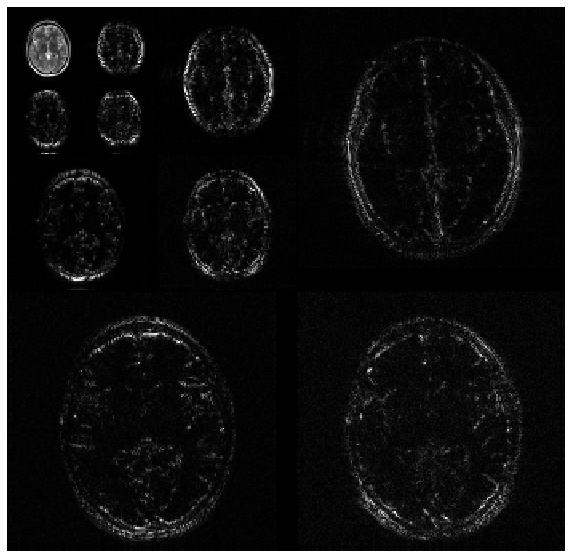

In [ ]:
plot_wavedec(img_cc, level=3)

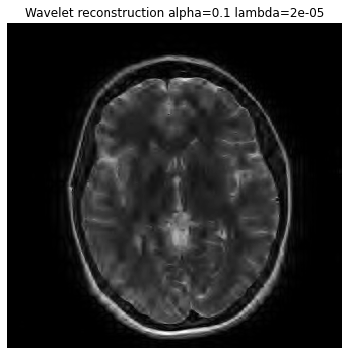

In [ ]:
lambd=2e-5
alpha=0.1
img_reg_wavelet = opt_reg_wavelet(kspace, max_iter=400, alpha=alpha, lambd=lambd)
img_reg_wavelet = medutils.visualization.center_crop(img_reg_wavelet, (nFE//2, nPE))
medutils.visualization.imshow(img_reg_wavelet, f'Wavelet reconstruction alpha={alpha} lambda={lambd}', figsize=(6,6))

Now you are ready to understand where the iterative (lower) level comes from and how this optimization can be optimized. Sometimese it is really important to step back a bit and look at classical approaches. :)